In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from joblib import Memory
import scipy.stats as st

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer  # Using RobustScaler for robust scaling
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import ElasticNet  # Meta-model for stacking 
# Tree-based models
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
train_file = r"C:\Users\malli\Documents\GitHub\Big-Mart-Sales-Prediction-Practice-Problem--\Datasets\train_cleaned_FE.csv"
df = pd.read_csv(train_file)

In [ ]:
train_file = r"C:\Users\malli\Documents\GitHub\Big-Mart-Sales-Prediction-Practice-Problem--\Datasets\train_cleaned_FE.csv"
df = pd.read_csv(train_file)
df = df.drop(columns=['MRP_by_Outlet_Type','Outlet_Location_Type', 'Outlet_Size', 'Item_Weight','Item_Fat_Content','Item_Visibility','Item_Type','Years_Since_Establishment','Mean_Sales_Outlet_Type','Avg_Sales_by_Location_Type'])



In [ ]:
categorical_cols = ['Item', 'Outlet', 'Outlet_Type']
numerical_cols = ['Item_MRP']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item               8523 non-null   object 
 1   Item_MRP           8523 non-null   float64
 2   Outlet             8523 non-null   object 
 3   Outlet_Type        8523 non-null   object 
 4   Item_Outlet_Sales  8523 non-null   float64
dtypes: float64(2), object(3)
memory usage: 333.1+ KB


In [ ]:
memory = Memory(location='cache_dir', verbose=0)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
], memory=memory)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [ ]:
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

In [ ]:
def tune_model(model, param_distributions, X, y, preprocessor, n_iter=10, cv=5, random_state=42):
    """
    Build a pipeline with the preprocessor and the model, and run RandomizedSearchCV.
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ], memory=memory)  # Cache intermediate steps
    
    rsearch = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=rmse_scorer,
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    rsearch.fit(X, y)
    print(f"Best params for {model.__class__.__name__}: {rsearch.best_params_}")
    return rsearch.best_estimator_

In [ ]:
gbr_params = {
    'model__n_estimators': st.randint(50, 300),
    'model__learning_rate': st.uniform(0.01, 0.2),
    'model__max_depth': st.randint(3, 10),
    'model__subsample': st.uniform(0.6, 0.4),  # Uniform between 0.6 and 1.0
    'model__min_samples_split': st.randint(2, 20),
    'model__min_samples_leaf': st.randint(1, 10)  # Added to help with regularization
}

xgb_params = {
    'model__n_estimators': st.randint(50, 300),
    'model__learning_rate': st.uniform(0.01, 0.2),
    'model__max_depth': st.randint(3, 10),
    'model__subsample': st.uniform(0.6, 0.4),
    'model__min_child_weight': st.randint(1, 10)
}

lgbm_params = {
    'model__n_estimators': st.randint(50, 300),
    'model__learning_rate': st.uniform(0.01, 0.2),
    'model__max_depth': st.randint(3, 10),
    'model__subsample': st.uniform(0.6, 0.4),
    'model__min_child_samples': st.randint(5, 50)
}

rf_params = {
    'model__n_estimators': st.randint(50, 300),
    'model__max_depth': st.randint(3, 15),
    'model__min_samples_split': st.randint(2, 20),
    'model__min_samples_leaf': st.randint(1, 20)
}

etr_params = {
    'model__n_estimators': st.randint(50, 300),
    'model__max_depth': st.randint(3, 15),
    'model__min_samples_split': st.randint(2, 20),
    'model__min_samples_leaf': st.randint(1, 20)
}

if catboost_available:
    cat_params = {
        'model__iterations': st.randint(50, 300),
        'model__learning_rate': st.uniform(0.01, 0.2),
        'model__depth': st.randint(3, 10)
    }

mlp_params = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': st.loguniform(1e-4, 1e-1),
    'model__learning_rate_init': st.uniform(0.001, 0.01)
}

In [ ]:
best_estimators = {}

print("Tuning GradientBoostingRegressor...")
best_estimators['gbr'] = tune_model(GradientBoostingRegressor(random_state=42), gbr_params, X, y, preprocessor)

print("Tuning XGBRegressor...")
best_estimators['xgb'] = tune_model(XGBRegressor(objective='reg:squarederror', random_state=42), xgb_params, X, y, preprocessor)

print("Tuning LGBMRegressor...")
best_estimators['lgbm'] = tune_model(LGBMRegressor(random_state=42), lgbm_params, X, y, preprocessor)

print("Tuning RandomForestRegressor...")
best_estimators['rf'] = tune_model(RandomForestRegressor(random_state=42), rf_params, X, y, preprocessor)

print("Tuning ExtraTreesRegressor...")
best_estimators['etr'] = tune_model(ExtraTreesRegressor(random_state=42), etr_params, X, y, preprocessor)

print("Tuning CatBoostRegressor...")
best_estimators['cat'] = tune_model(CatBoostRegressor(verbose=0, random_state=42), cat_params, X, y, preprocessor)

print("Tuning MLPRegressor...")
best_estimators['mlp'] = tune_model(MLPRegressor(random_state=42, max_iter=500), mlp_params, X, y, preprocessor)

Tuning GradientBoostingRegressor...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for GradientBoostingRegressor: {'model__learning_rate': 0.021282315805420053, 'model__max_depth': 6, 'model__min_samples_leaf': 6, 'model__min_samples_split': 3, 'model__n_estimators': 241, 'model__subsample': 0.996884623716487}
Tuning XGBRegressor...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for XGBRegressor: {'model__learning_rate': 0.1000998503939086, 'model__max_depth': 4, 'model__min_child_weight': 4, 'model__n_estimators': 138, 'model__subsample': 0.9862528132298237}
Tuning LGBMRegressor...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 8523, number of used features: 15
[LightGBM]

c:\Users\malli\.conda\envs\test\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
stacking_estimators = [(name, estimator) for name, estimator in best_estimators.items()]

meta_model = ElasticNet(random_state=42, max_iter=10000)  # Meta-model for stacking

# Note: Removing passthrough=True so that the meta-model only uses base model predictions.
stacking_ensemble = StackingRegressor(
    estimators=stacking_estimators,
    final_estimator=meta_model,
    cv=5,          
    n_jobs=1,
    passthrough=False
)

# Fit the stacking ensemble on the raw training data (each pipeline handles its own preprocessing)
stacking_ensemble.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 8523, number of used features: 15
[LightGBM] [Info] Start training from score 2181.288915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\malli\.conda\envs\test\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 15
[LightGBM] [Info] Start training from score 2172.545146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\malli\.conda\envs\test\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\malli\.conda\envs\test\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\malli\.conda\envs\test\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\malli\.conda\envs\test\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\malli\.conda\envs\test\Lib\site-pac

StackingRegressor(cv=5,
                  estimators=[('gbr',
                               Pipeline(memory=Memory(location=cache_dir\joblib),
                                        steps=[('preprocessor',
                                                ColumnTransformer(transformers=[('num',
                                                                                 Pipeline(steps=[('imputer',
                                                                                                  SimpleImputer()),
                                                                                                 ('yeo_johnson',
                                                                                                  PowerTransformer()),
                                                                                                 ('scaler',
                                                                                                  RobustScaler())]),
                                                                                 ['Item_MRP']),
                                                                                ('cat',
                                                                                 Pipeline(memory=Memory(location=cache_dir\joblib),
                                                                                          steps=[('imputer',...
                                                                                          steps=[('imputer',
                                                                                                  SimpleImputer(strategy='most_frequent')),
                                                                                                 ('onehot',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['Item',
                                                                                  'Outlet',
                                                                                  'Outlet_Type'])])),
                                               ('model',
                                                MLPRegressor(activation='tanh',
                                                             alpha=0.06541210527692734,
                                                             learning_rate_init=0.002818249672071006,
                                                             max_iter=500,
                                                             random_state=42))]))],
                  final_estimator=ElasticNet(max_iter=10000, random_state=42),
                  n_jobs=1)

In [ ]:
test_file = r"C:\Users\malli\Documents\GitHub\Big-Mart-Sales-Prediction-Practice-Problem--\Datasets\test_cleaned_FE.csv"
test_data = pd.read_csv(test_file)
test_data = test_data.drop(columns=['MRP_by_Outlet_Type','Outlet_Location_Type', 'Outlet_Size', 'Item_Weight','Item_Fat_Content','Item_Visibility','Item_Type','Years_Since_Establishment','Mean_Sales_Outlet_Type','Avg_Sales_by_Location_Type'], errors='ignore')

predictions = stacking_ensemble.predict(test_data)
test_data['Predicted_Item_Outlet_Sales'] = predictions
test_data['Predicted_Item_Outlet_Sales_abs'] = test_data['Predicted_Item_Outlet_Sales'].abs()

output_file = r"I:\My Drive\Data Science\Case Comps\Feburary Internship Retail Prediction\submissons\MOAwithnoelasticandminimalfeaturesASF.csv"
test_data.to_csv(output_file, index=False)
print("Predictions saved to:", output_file)


Predictions saved to: I:\My Drive\Data Science\Case Comps\Feburary Internship Retail Prediction\submissons\MOAwithnoelasticandminimalfeaturesASF.csv


In [ ]:
# Analyzing Meta-Model Coefficients
meta_estimator = stacking_ensemble.final_estimator_

print("Meta Model Coefficients:")
for name, coef in zip([name for name, _ in stacking_estimators], meta_estimator.coef_):
    print(f"  {name}: {coef}")
print("Meta Model Intercept:", meta_estimator.intercept_)

Meta Model Coefficients:
  gbr: -0.12180638998243301
  xgb: -0.05600855194513202
  lgbm: -0.04028870821763825
  rf: 0.03881769584673853
  etr: 0.3188654342320598
  cat: 0.8355015004131312
  mlp: 0.04172243281336597
Meta Model Intercept: -28.100214109592798


### Conclusion: CatRegressor has the biggetst contribution, followed by ExtraTreesRegressor.

In [ ]:
import joblib 
# Saved the trained stacking ensemble model
model_path = r"C:\Users\malli\Documents\GitHub\Big-Mart-Sales-Prediction-Practice-Problem--\Saved Models\final_model_wFEGOATEDGOATEDASK.pkl"
with open(model_path, "wb") as f:
    joblib.dump(stacking_ensemble, f)


# Feature Importance Evauation

GradientBoostingRegressor Feature Importances:
                                 feature  importance
0                          num__Item_MRP    0.549080
1570      cat__Outlet_Type_Grocery Store    0.307041
1565                  cat__Outlet_OUT027    0.063122
1573  cat__Outlet_Type_Supermarket Type3    0.054280
1571  cat__Outlet_Type_Supermarket Type1    0.003681
...                                  ...         ...
547                      cat__Item_FDK08    0.000000
546                      cat__Item_FDK04    0.000000
544                      cat__Item_FDK02    0.000000
543                      cat__Item_FDJ60    0.000000
787                      cat__Item_FDQ15    0.000000

[1574 rows x 2 columns]


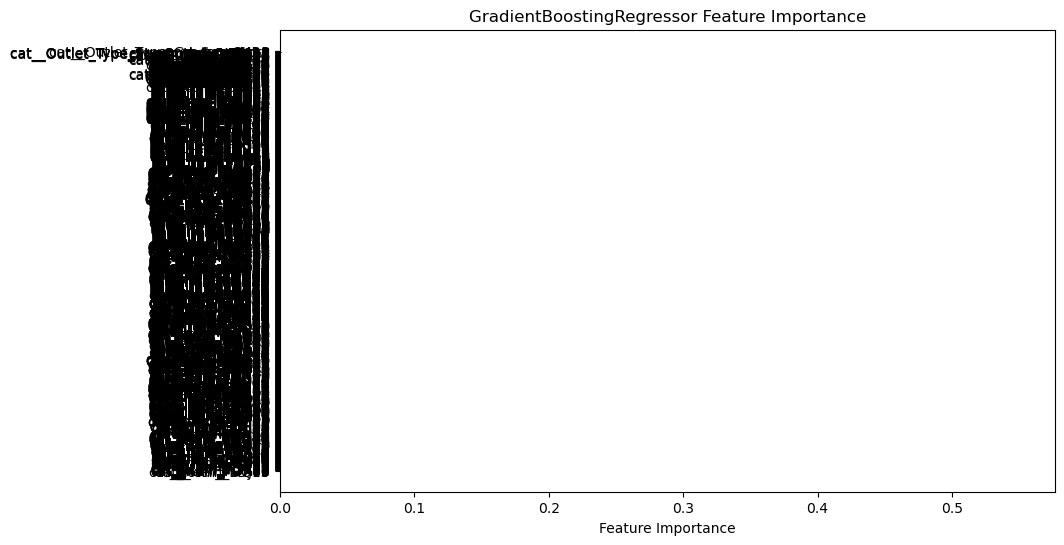

XGBRegressor Feature Importances:
                                 feature  importance
1570      cat__Outlet_Type_Grocery Store    0.261804
0                          num__Item_MRP    0.091995
1565                  cat__Outlet_OUT027    0.083353
1563                  cat__Outlet_OUT018    0.016700
1571  cat__Outlet_Type_Supermarket Type1    0.011340
...                                  ...         ...
551                      cat__Item_FDK15    0.000000
550                      cat__Item_FDK14    0.000000
548                      cat__Item_FDK09    0.000000
547                      cat__Item_FDK08    0.000000
1573  cat__Outlet_Type_Supermarket Type3    0.000000

[1574 rows x 2 columns]


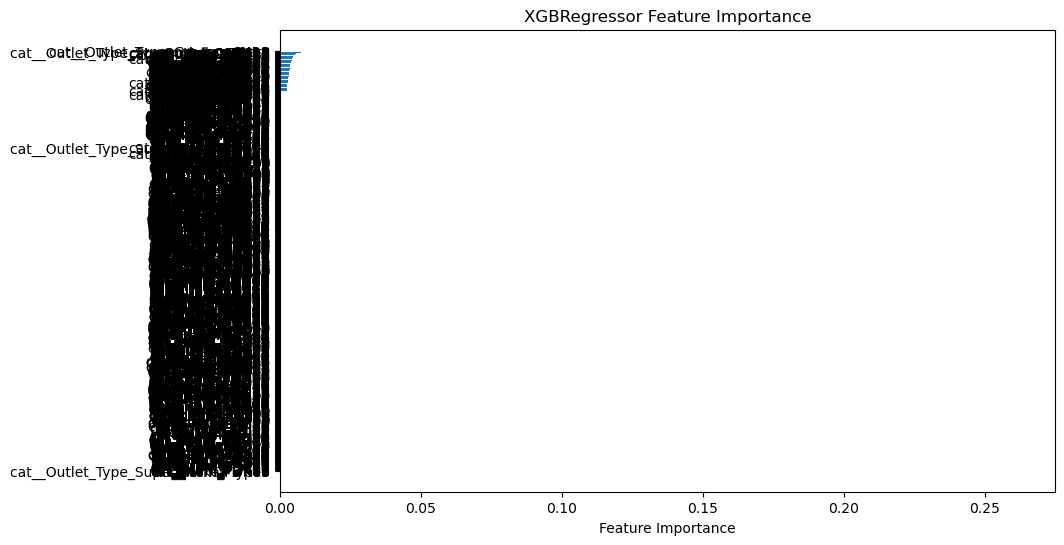

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 283
[LightGBM] [Info] Number of data points in the train set: 8523, number of used features: 15
[LightGBM] [Info] Start training from score 2181.288915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

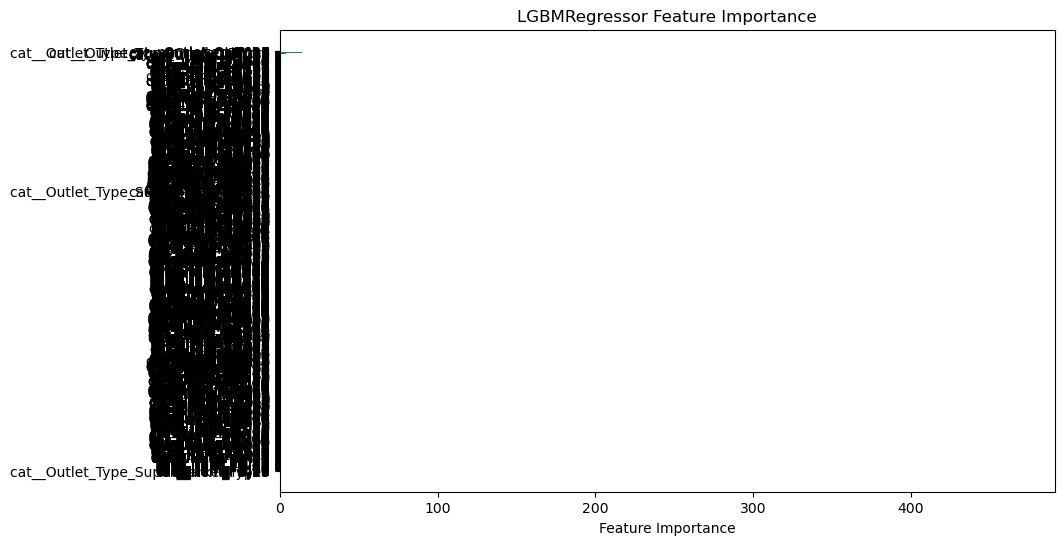

RandomForestRegressor Feature Importances:
                                 feature  importance
0                          num__Item_MRP    0.553894
1570      cat__Outlet_Type_Grocery Store    0.321089
1565                  cat__Outlet_OUT027    0.061923
1573  cat__Outlet_Type_Supermarket Type3    0.061001
1571  cat__Outlet_Type_Supermarket Type1    0.001222
...                                  ...         ...
525                      cat__Item_FDJ32    0.000000
524                      cat__Item_FDJ28    0.000000
523                      cat__Item_FDJ27    0.000000
522                      cat__Item_FDJ26    0.000000
787                      cat__Item_FDQ15    0.000000

[1574 rows x 2 columns]


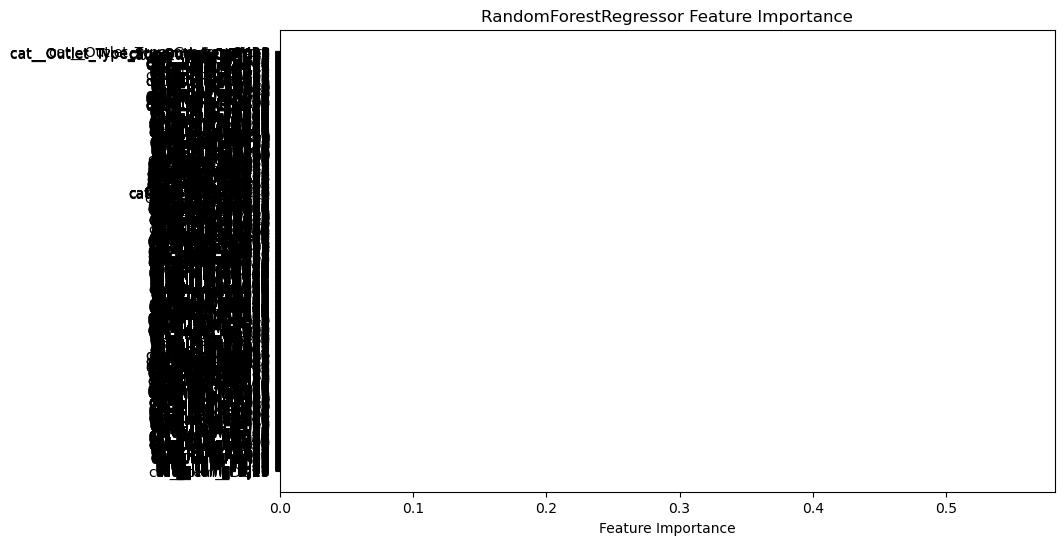

ExtraTreesRegressor Feature Importances:
                                 feature  importance
0                          num__Item_MRP    0.566210
1570      cat__Outlet_Type_Grocery Store    0.301807
1573  cat__Outlet_Type_Supermarket Type3    0.062855
1565                  cat__Outlet_OUT027    0.062566
1571  cat__Outlet_Type_Supermarket Type1    0.002863
...                                  ...         ...
524                      cat__Item_FDJ28    0.000000
523                      cat__Item_FDJ27    0.000000
522                      cat__Item_FDJ26    0.000000
521                      cat__Item_FDJ22    0.000000
787                      cat__Item_FDQ15    0.000000

[1574 rows x 2 columns]


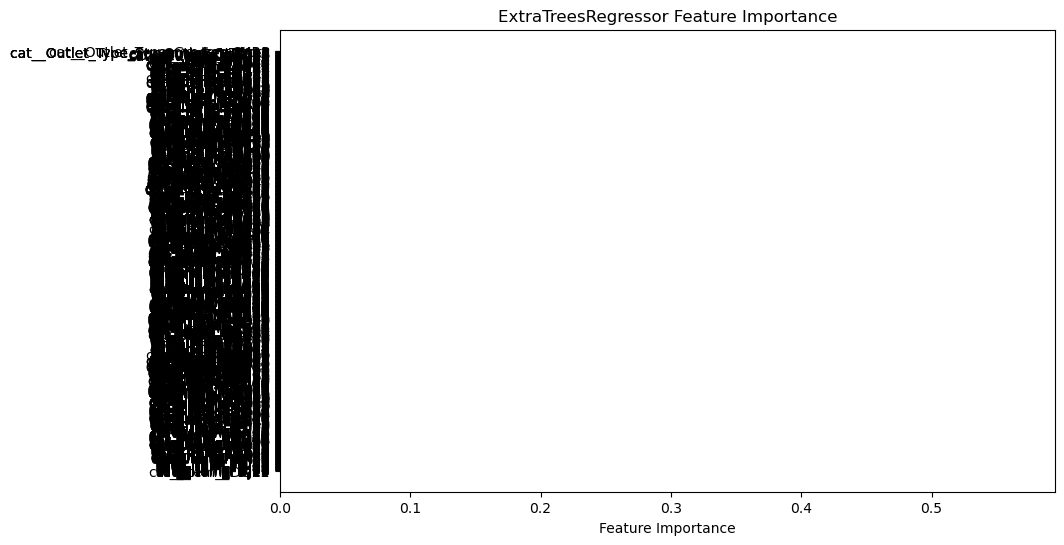

In [ ]:
gbr_pipeline = best_estimators['gbr']

# Fit the pipeline
gbr_pipeline.fit(X, y)

gbr_model = gbr_pipeline.named_steps['model']

importances_gbr = gbr_model.feature_importances_

# Get the feature names from the preprocessor
try:
    # This will include names from the numerical and one-hot encoded categorical features
    feature_names_gbr = list(gbr_pipeline.named_steps['preprocessor'].get_feature_names_out())
except AttributeError:
    # Fallback: if get_feature_names_out is not available, use the original order (less precise)
    feature_names_gbr = numerical_cols + categorical_cols

# Create a DataFrame to display the importances
importance_df_gbr = pd.DataFrame({
    'feature': feature_names_gbr,
    'importance': importances_gbr
}).sort_values(by='importance', ascending=False)

print("GradientBoostingRegressor Feature Importances:")
print(importance_df_gbr)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_gbr['feature'], importance_df_gbr['importance'])
plt.xlabel("Feature Importance")
plt.title("GradientBoostingRegressor Feature Importance")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

# -------------------------------
# 2. XGBRegressor
# -------------------------------
xgb_pipeline = best_estimators['xgb']

# Fit the pipeline
xgb_pipeline.fit(X, y)

# Extract the model from the pipeline
xgb_model = xgb_pipeline.named_steps['model']

# Get feature importances
importances_xgb = xgb_model.feature_importances_

# Retrieve feature names from the preprocessor
try:
    feature_names_xgb = list(xgb_pipeline.named_steps['preprocessor'].get_feature_names_out())
except AttributeError:
    feature_names_xgb = numerical_cols + categorical_cols

# Create a DataFrame for importances
importance_df_xgb = pd.DataFrame({
    'feature': feature_names_xgb,
    'importance': importances_xgb
}).sort_values(by='importance', ascending=False)

print("XGBRegressor Feature Importances:")
print(importance_df_xgb)

# Plot the importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_xgb['feature'], importance_df_xgb['importance'])
plt.xlabel("Feature Importance")
plt.title("XGBRegressor Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# -------------------------------
# 3. LGBMRegressor
# -------------------------------
lgbm_pipeline = best_estimators['lgbm']

# Fit the pipeline
lgbm_pipeline.fit(X, y)

# Extract the model
lgbm_model = lgbm_pipeline.named_steps['model']

# Get feature importances
importances_lgbm = lgbm_model.feature_importances_

# Get feature names from the preprocessor
try:
    feature_names_lgbm = list(lgbm_pipeline.named_steps['preprocessor'].get_feature_names_out())
except AttributeError:
    feature_names_lgbm = numerical_cols + categorical_cols

# Create DataFrame for importances
importance_df_lgbm = pd.DataFrame({
    'feature': feature_names_lgbm,
    'importance': importances_lgbm
}).sort_values(by='importance', ascending=False)

print("LGBMRegressor Feature Importances:")
print(importance_df_lgbm)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_lgbm['feature'], importance_df_lgbm['importance'])
plt.xlabel("Feature Importance")
plt.title("LGBMRegressor Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# -------------------------------
# 4. RandomForestRegressor
# -------------------------------
rf_pipeline = best_estimators['rf']

# Fit the pipeline
rf_pipeline.fit(X, y)

# Extract the model
rf_model = rf_pipeline.named_steps['model']

# Get feature importances
importances_rf = rf_model.feature_importances_

# Retrieve feature names from the preprocessor
try:
    feature_names_rf = list(rf_pipeline.named_steps['preprocessor'].get_feature_names_out())
except AttributeError:
    feature_names_rf = numerical_cols + categorical_cols

# Create DataFrame for importances
importance_df_rf = pd.DataFrame({
    'feature': feature_names_rf,
    'importance': importances_rf
}).sort_values(by='importance', ascending=False)

print("RandomForestRegressor Feature Importances:")
print(importance_df_rf)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_rf['feature'], importance_df_rf['importance'])
plt.xlabel("Feature Importance")
plt.title("RandomForestRegressor Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# -------------------------------
# 5. ExtraTreesRegressor
# -------------------------------
etr_pipeline = best_estimators['etr']

# Fit the pipeline
etr_pipeline.fit(X, y)

# Extract the model
etr_model = etr_pipeline.named_steps['model']

# Get feature importances
importances_etr = etr_model.feature_importances_

# Retrieve feature names from the preprocessor
try:
    feature_names_etr = list(etr_pipeline.named_steps['preprocessor'].get_feature_names_out())
except AttributeError:
    feature_names_etr = numerical_cols + categorical_cols

# Create DataFrame for importances
importance_df_etr = pd.DataFrame({
    'feature': feature_names_etr,
    'importance': importances_etr
}).sort_values(by='importance', ascending=False)

print("ExtraTreesRegressor Feature Importances:")
print(importance_df_etr)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df_etr['feature'], importance_df_etr['importance'])
plt.xlabel("Feature Importance")
plt.title("ExtraTreesRegressor Feature Importance")
plt.gca().invert_yaxis()
plt.show()


CatBoostRegressor Feature Importances:
                                 feature  importance
1570      cat__Outlet_Type_Grocery Store   35.527179
0                          num__Item_MRP   33.176672
1565                  cat__Outlet_OUT027   12.797988
1573  cat__Outlet_Type_Supermarket Type3   10.710886
1571  cat__Outlet_Type_Supermarket Type1    4.062139
...                                  ...         ...
600                      cat__Item_FDL32    0.000000
599                      cat__Item_FDL28    0.000000
598                      cat__Item_FDL27    0.000000
597                      cat__Item_FDL26    0.000000
787                      cat__Item_FDQ15    0.000000

[1574 rows x 2 columns]


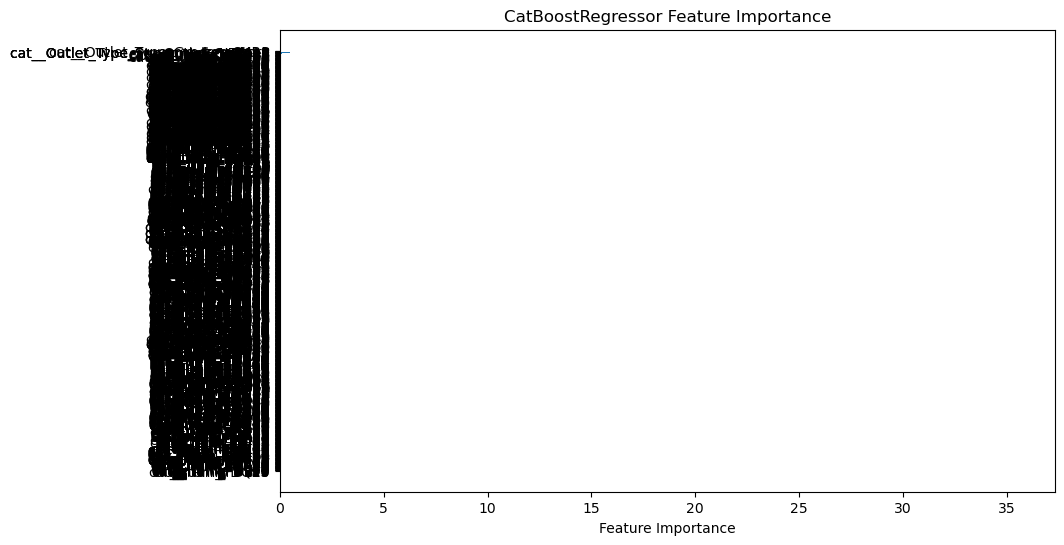

In [13]:
# -------------------------------
# 6. CatBoostRegressor
# -------------------------------
cat_pipeline = best_estimators['cat']

if catboost_available:
    # Fit the pipeline
    cat_pipeline.fit(X, y)

    # Extract the model
    catboost_model = cat_pipeline.named_steps['model']

    # Get feature importances
    importances_catboost = catboost_model.feature_importances_

    # Retrieve feature names from the preprocessor
    try:
        feature_names_catboost = list(cat_pipeline.named_steps['preprocessor'].get_feature_names_out())
    except AttributeError:
        feature_names_catboost = numerical_cols + categorical_cols

    # Create DataFrame for importances
    importance_df_catboost = pd.DataFrame({
        'feature': feature_names_catboost,
        'importance': importances_catboost
    }).sort_values(by='importance', ascending=False)

    print("CatBoostRegressor Feature Importances:")
    print(importance_df_catboost)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df_catboost['feature'], importance_df_catboost['importance'])
    plt.xlabel("Feature Importance")
    plt.title("CatBoostRegressor Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()